# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/23/2024 by AFS

In [1]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore
# import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'christina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07232024


In [4]:
if current_user == 'christina':
    base_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/scripts/'
    data_dir = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
    tfr_dir  = f'{data_dir}tfr/'
    anat_dir = f'{data_dir}anat/'
elif current_user == 'alie':
    # base_dir = '/hpc/users/finka03/NeuroCluster/NeuroCluster/'
    # swb_dir  = '/sc/arion/projects/guLab/Alie/SWB/'
    # tfr_dir  = f'{swb_dir}ephys_analysis/data/'
    # beh_dir  = f'{swb_dir}swb_behav_models/data/behavior_preprocessed/'
    # anat_dir = f'{swb_dir}ephys_analysis/recon_labels/'
    # save_dir = f'{base_dir}/data/'
    
    base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/NeuroCluster/scripts/'
    data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
    tfr_dir  = f'{data_dir}ephys_analysis/data/'
    beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
    anat_dir = f'{data_dir}anat_recons/'

In [5]:
# load functions 
import sys
sys.path.append(f'{base_dir}')
# sys.path.append(f'{base_dir}scripts/')

from tfr_cluster_test import *
from helper_utils import *
from plotting_utils import * 

# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [6]:
# load epoched data for single subj
if current_user == 'alie':
    permute_var = 'decisionCPE'
    subj_id     = 'MS002'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
elif current_user == 'christina':
    permute_var = 'expected_value'
    subj_id     = 'MS009'   
    power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}_tfr.h5')[0]

Reading /Users/christinamaher/Documents/GitHub/NeuroCluster/tfr/MS009_tfr.h5 ...
Adding metadata with 6 columns


In [7]:
# temp just for CMM data 

# add ev_zscore to power_epochs metadata
behavior = pd.read_csv('/Users/christinamaher/Desktop/old_preprocess/MS009/MS009_clean.csv')

# add ev_zscore to the power_epochs metadata 
power_epochs.metadata['ev_zscore'] = behavior['expected_value'].values

# drop trials == no_hint from power_epochs
power_epochs = power_epochs["condition == 'hint'"]

In [8]:
# set ROI for single ROI anaylsis 
if current_user == 'alie':
#     roi = 'ains'
    # set all variables included mutliple regression 
    multi_reg_vars = ['GambleChoice','TrialEV','decisionCPE']
    # set main variable of interest for permutations 
    permute_var = 'decisionCPE'
    # load subj behavior data 
#     beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
    beh_df = power_epochs.metadata.copy()
    # beh_df['subj_id'] = subj_id
    # add TrialEV to df
    beh_df['TrialEV'] = beh_df.GambleEV - beh_df.SafeBet
    # clean subj dataframe from fail trials/nan values in vars of interest     
    # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
#     beh_df = beh_df[(beh_df.Outcome=='good')|(beh_df.Outcome=='bad')]
    
    # zscore continuous variables 
    beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
    # format final beh_df
    beh_df = beh_df[multi_reg_vars].reset_index(drop=True) 
    # convert choice to categorical variable
    beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')

elif current_user == 'christina':
    beh_df = prepare_regressor_df(power_epochs)
    # assign column names for to multi_reg_vars list
    multi_reg_vars = beh_df.columns.tolist()
    ## new function for getting elecs in ROI
    roi = ['lpfc','ofc']
    roi_subj_elecs = prepare_anat_dic(roi, f'{anat_dir}master_labels.csv')
    roi_subj_elecs


In [9]:
#### class TFR_Cluster_Test dev + debugging

if current_user == 'alie':

    # subset single electrode tfr data + behav data
    dev_ch_idx     = power_epochs.ch_names.index('laims2-laims3')
    ch_name        = 'laims2-laims3'
    tfr_data       = np.squeeze(power_epochs._data[:,dev_ch_idx,:,:].copy())
    predictor_data = beh_df.copy()
    
    # predictor_data = predictor_data.drop(columns='subj_id')

elif current_user == 'christina':
    
        # subset single electrode tfr data + behav data
        # predictor_data = predictor_data.drop(columns=['condition','chosen_shape_current_trial','chosen_color_current_trial','chosen_shape_previous_trial','chosen_color_previous_trial','ev'])
        tfr_data = np.squeeze(power_epochs._data[:,0,:,:].copy())
        ch_name = power_epochs.info['ch_names'][0]
        predictor_data = beh_df.copy()

In [10]:
# drop nan values from predictor data
predictor_data = predictor_data.dropna()
predictor_data

,rd,r,ev_zscore
36,shape,1,0.166667
37,shape,0,0.304334
38,shape,1,0.166666
39,shape,1,0.304335
40,shape,1,0.419259
...,...,...,...
211,color,1,0.781656
212,color,1,0.817726
213,color,0,0.847838
214,color,1,0.707775


## Step 2: Find Real Clusters
- Use TFRClusterTest class code to run multivariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it.

In [11]:
permute_var = 'ev_zscore'
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')
cluster_test

In [12]:
betas, tstats = cluster_test.tfr_regression()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 42576 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    4.3s finished


In [13]:
tstats

array([[-1.17468095, -1.18797488, -1.20150434, ..., -2.18077116,
        -2.17789314, -2.17491742],
       [-1.26160309, -1.27314928, -1.28487812, ..., -1.88617688,
        -1.88055175, -1.8750149 ],
       [-1.38549875, -1.39262364, -1.39987974, ..., -1.40210248,
        -1.40792288, -1.41390276],
       ...,
       [-0.62302808, -0.49697702, -0.46137801, ..., -0.6401826 ,
        -0.68251559, -0.75881873],
       [ 0.31276651, -0.08377359, -0.50590195, ...,  0.60456023,
         0.54167589,  0.46277499],
       [ 0.91402539,  0.5231472 ,  0.08411767, ...,  0.17151176,
         0.30293207,  0.44100787]])

In [14]:
beh_variables = cluster_test.predictor_data.columns.tolist().copy()
control_variables = [var for var in beh_variables if var != cluster_test.permute_var] 

## Step 3: Compute Null Cluster Distribution from Permutations

In [15]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

In [16]:
null_cluster_distribution

[[901.509957934104,
  364.19728069466873,
  305.6622492393617,
  263.3019903715422,
  319.0236427179732,
  399.10096849770844,
  1382.3021295243277,
  1171.5087059863067,
  288.8277977182623,
  246.60011111837662],
 [-193.9141592528981,
  -2359.3487331306446,
  -278.67945008101645,
  -221.6743748640577,
  -312.38043799114,
  -744.8522638014323,
  -506.84724242337563,
  -1155.8309641279486,
  -545.3020908354268,
  -1889.2248683894777]]

#### POLISHED WORKFLOW

In [21]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR
betas, tstats = cluster_test.tfr_regression()

# Step for plotting - save matrices with location of t-stats that survive significance thresholding
tstat_threshold = cluster_test.threshold_tfr_tstat(tstats)

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) #compute_cluster_pvalue cluster_significance_test



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 9200 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 44208 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    3.0s finished


#### POLISHED PLOTTING 

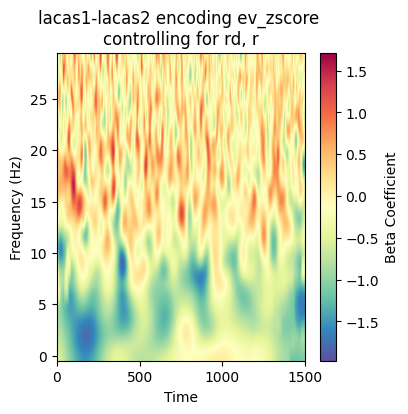

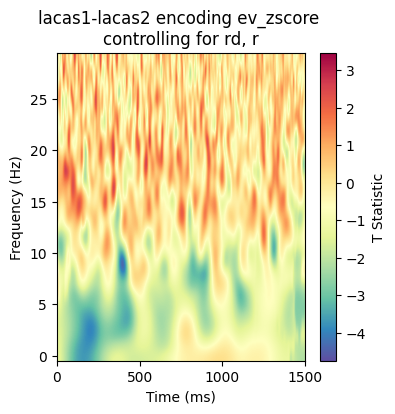

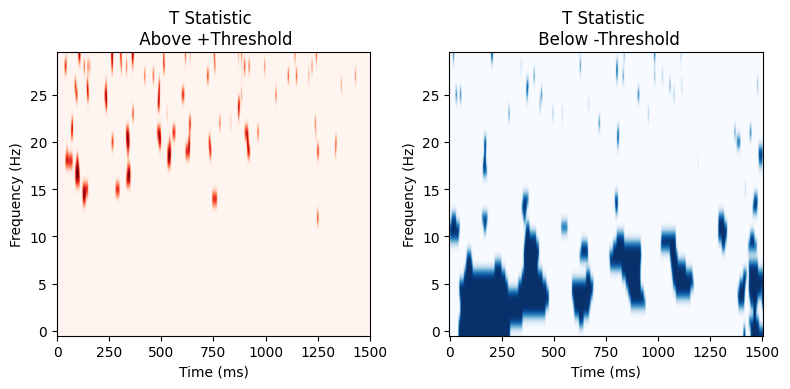

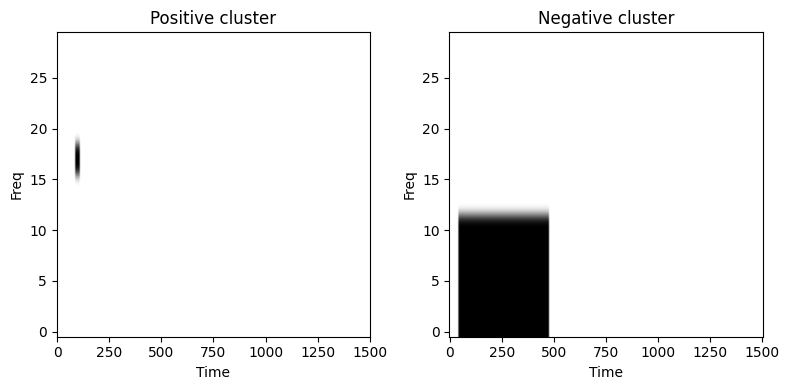

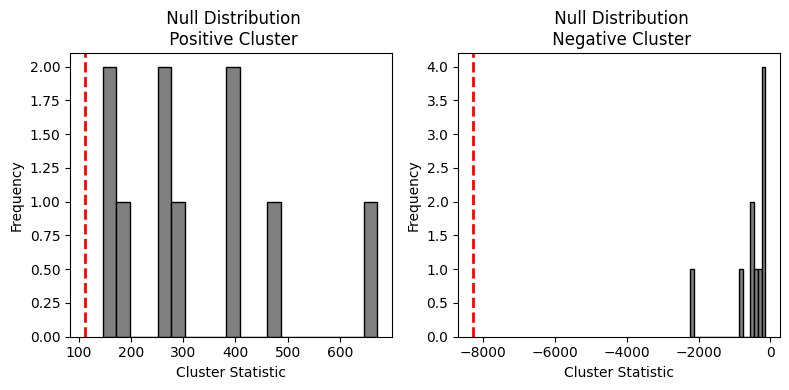

In [25]:
results_plot = plot_neurocluster_results(betas,cluster_test, max_cluster_data, null_cluster_distribution, tstats, tstat_threshold)


In [ ]:
# To implement FDR correction: 
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# multitest.multipletests(p_upper, method='fdr_bh')